In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bcb4c00982bd4962799d0a9fe7a1e5a1548dab3599e8397f8f00e44a60d0e0c2
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


✅ Data shape: (27531, 18)

📘 X_train_scaled (first 5 rows):
        BVP       EDA      TEMP      AccX      AccY      AccZ        HR  \
0 -0.236276 -0.708252 -1.023767  1.591055 -1.029676  1.056229 -0.514252   
1  1.095257  0.592021  0.103095 -1.077047  0.968156 -0.320707  1.334348   
2  0.127289  0.599888  1.245979 -1.264282 -0.167866 -0.891632 -0.769734   
3 -0.525128 -0.668819  0.722602 -0.562150 -1.108023  0.015131  0.376534   
4  0.985385 -0.682799  0.017646 -1.123855 -0.324559 -0.555793  0.192937   

      Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1  \
0  1.259641 -0.371131  0.676199 -0.566670  0.575726 -0.635747 -0.516289   
1 -0.646587 -0.381736  1.718746  0.115653  0.508169 -0.258007 -0.336352   
2 -0.613363  0.588219 -0.732973 -0.614810  0.875468  1.833919  4.914687   
3 -0.047946 -0.257798  1.650485 -0.696863  0.262133  0.317078  0.218833   
4  0.200207  0.346404  0.337054 -0.298132 -0.712601  1.091021 -0.577340   

     Gamma2   Attention   Meditation  

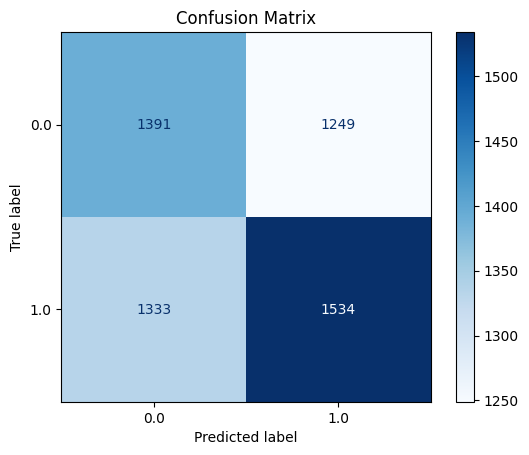

   Sample  Predicted_Class  Uncertainty (1 - max prob)
0       0              0.0                    0.000203
1       1              1.0                    0.001396
2       2              1.0                    0.108971
3       3              1.0                    0.313661
4       4              0.0                    0.000214


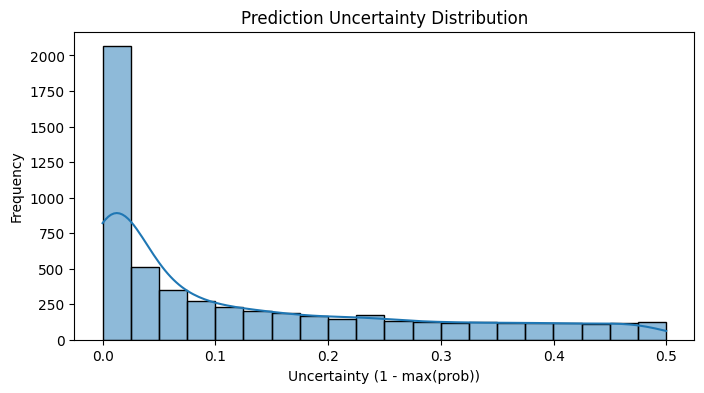

 98%|===================| 195/200 [00:15<00:00]       

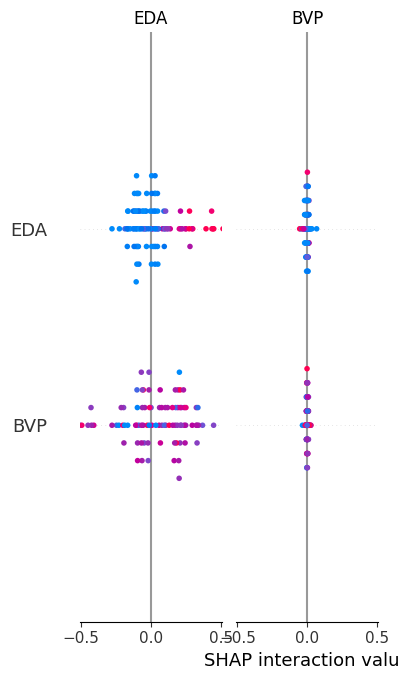


🟡 LIME Explanation for First Sample:
[('EDA <= -0.66', -0.16259108837515132), ('TEMP > 0.75', 0.10475118729729616), ('HR > 0.59', -0.05472165268893089), ('AccZ <= -0.62', -0.04767211810422636), ('AccX > 0.56', -0.039408965495021014), ('-0.05 < AccY <= 0.50', 0.020698346181357134), ('-0.38 <  Gamma2 <= 0.23', -0.01298917571228874), ('-0.39 <  Beta1 <= 0.27', 0.008773615980536347), (' Alpha1 > 0.26', 0.007926824500821205), (' Theta > 0.21', 0.007660083522063101)]

✅ Results saved to 'BrainNetwork_Model_Results.xlsx'


In [2]:
# brain_network_classifier_uncertainty_xai.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings("ignore")

# Hypothetical Brain Network Classifier
class BrainNetworkClassifier:
    def __init__(self, n_nodes=100, learning_rate=0.01, random_state=42):
        self.n_nodes = n_nodes
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.weights = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.classes_ = np.unique(y)
        self.input_dim = X.shape[1]
        self.output_dim = len(self.classes_)
        self.weights = np.random.randn(self.input_dim, self.output_dim)
        for _ in range(self.n_nodes):
            outputs = X @ self.weights
            probs = self._softmax(outputs)
            error = y - probs
            self.weights += self.learning_rate * X.T @ error / X.shape[0]
        return self

    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)

    def predict_proba(self, X):
        if self.weights is None:
            raise ValueError("Model not trained.")
        outputs = X @ self.weights
        return self._softmax(outputs)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

def compute_uncertainty(probs):
    return 1 - np.max(probs, axis=1)

def main():
    data = pd.read_csv("/content/drive/MyDrive/CODE/Prince Okyere/DOWN/MEFAR_DOWN.csv")
    data.dropna(inplace=True)
    print("✅ Data shape:", data.shape)

    label_encoder = LabelEncoder()
    data['class'] = label_encoder.fit_transform(data['class'])
    classes = label_encoder.classes_.astype(str)

    X = data.drop('class', axis=1)
    y = data['class']
    encoder = OneHotEncoder()
    y_encoded = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    y_train_class = np.argmax(y_train, axis=1)
    y_test_class = np.argmax(y_test, axis=1)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = BrainNetworkClassifier()
    clf.fit(X_train_scaled, y_train)

    y_pred_prob = clf.predict_proba(X_test_scaled)
    y_pred_class = clf.predict(X_test_scaled)

    # Display scaled training and test data as DataFrames
    X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

    # Predicted class as DataFrame
    y_pred_class_df = pd.DataFrame({"Predicted Class": label_encoder.inverse_transform(y_pred_class)})

    # Predicted probabilities as DataFrame
    class_labels = [f"Class_{cls}" for cls in label_encoder.classes_]
    y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=class_labels)

    # Display all
    print("\n📘 X_train_scaled (first 5 rows):")
    print(X_train_df.head())

    print("\n📗 X_test_scaled (first 5 rows):")
    print(X_test_df.head())

    print("\n📙 Predicted Classes (first 5 rows):")
    print(y_pred_class_df.head())

    print("\n📕 Predicted Probabilities (first 5 rows):")
    print(y_pred_prob_df.head())


    acc = accuracy_score(y_test_class, y_pred_class)
    prec = precision_score(y_test_class, y_pred_class, average='weighted')
    rec = recall_score(y_test_class, y_pred_class, average='weighted')
    f1 = f1_score(y_test_class, y_pred_class, average='weighted')
    mcc = matthews_corrcoef(y_test_class, y_pred_class)
    report = classification_report(y_test_class, y_pred_class, target_names=classes)
    cm = confusion_matrix(y_test_class, y_pred_class)

    print("\n📊 Classification Report:\n", report)

    youden_index = np.nan
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall_score(y_test_class, y_pred_class)
        youden_index = sensitivity + specificity - 1

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    uncertainties = compute_uncertainty(y_pred_prob)
    uncertainty_df = pd.DataFrame({
        "Sample": np.arange(len(uncertainties)),
        "Predicted_Class": label_encoder.inverse_transform(y_pred_class),
        "Uncertainty (1 - max prob)": uncertainties
    })
    print(uncertainty_df.head())

    plt.figure(figsize=(8, 4))
    sns.histplot(uncertainties, bins=20, kde=True)
    plt.title("Prediction Uncertainty Distribution")
    plt.xlabel("Uncertainty (1 - max(prob))")
    plt.ylabel("Frequency")
    plt.show()

    rf = RandomForestClassifier()
    rf.fit(X_train_scaled, y_train_class)

    explainer = shap.Explainer(rf, X_train_scaled)
    shap_values = explainer(X_test_scaled[:100])
    shap.summary_plot(shap_values, X_test.iloc[:100], show=True)

    lime_exp = LimeTabularExplainer(X_train_scaled, feature_names=X.columns,
                                    class_names=classes, discretize_continuous=True)
    lime_result = lime_exp.explain_instance(X_test_scaled[0], rf.predict_proba, num_features=10)
    print("\n🟡 LIME Explanation for First Sample:")
    print(lime_result.as_list())

    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Youden Index"],
        "Value": [acc, prec, rec, f1, mcc, youden_index]
    })
    results_df.to_excel("BrainNetwork_Model_Results.xlsx", index=False)
    print("\n✅ Results saved to 'BrainNetwork_Model_Results.xlsx'")

if __name__ == "__main__":
    main()
